In [1]:
# SETUP:

# first import the whole package
import PyAPD

# then load all the functions in the .py files in the .../PyAPD/ directory:
from PyAPD import *

import copy

torch.set_printoptions(precision=10) # show more digits

device = "cuda" if torch.cuda.is_available() else "cpu"
dt = torch.float64
torch.set_default_dtype(dt)

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [2]:
def adjust_X_As(self,backend="auto",adjust_As = False):
    if not self.optimality:
        print("Find optimal W first!")
    else:
        D_ij = ((self.y - self.x) | self.a.matvecmult(self.y - self.x)) - self.w
        grain_indices = D_ij.argmin(dim=0,backend=backend).ravel()
        new_X0 = torch.bincount(grain_indices, self.Y[:,0], minlength = self.N)
        new_X1 = torch.bincount(grain_indices, self.Y[:,1], minlength = self.N)

        normalisation = torch.bincount(grain_indices,minlength=self.N)

        if self.D == 3:
            new_X2 = torch.bincount(grain_indices,Y[:,2],minlength=N)
            self.X = torch.stack([new_X0/normalisation, new_X1/normalisation,new_X2/normalisation],dim=1)
        else:
            self.X = torch.stack([new_X0/normalisation, new_X1/normalisation],dim=1)

        if adjust_As:
            YY_XX_new = apd1.Y - apd1.X[grain_indices]
            tensor_prod = torch.einsum('bc,bd->bcd', YY_XX_new, YY_XX_new)
            a00 = torch.bincount(grain_indices, tensor_prod[:,0,0], minlength=apd1.N)
            a01 = torch.bincount(grain_indices, tensor_prod[:,0,1], minlength=apd1.N)
            a11 = torch.bincount(grain_indices, tensor_prod[:,1,1], minlength=apd1.N)
            As0_new = torch.stack([4.0*a00/normalisation, 4.0*a01/normalisation],dim=1)
            As1_new = torch.stack([4.0*a01/normalisation, 4.0*a11/normalisation],dim=1)
            As_new = torch.linalg.inv(torch.stack([As0_new, As1_new],dim=1))
            ee,vv = torch.linalg.eigh(As_new)
            ratios = ee[:,1] / ee[:,0]
            major_axes = torch.sqrt(ratios)
            minor_axes = 1/major_axes
            ee_normalised = torch.stack([major_axes,minor_axes],dim=1)
            self.As = (vv @ torch.diag_embed(ee_normalised) @ vv.mT.conj())
            self.a = LazyTensor(self.As.view(self.N, 1, self.D * self.D))

        self.optimality = False
        self.x = LazyTensor(self.X.view(self.N, 1, self.D))

def new_Lloyds_algorithm(self,K=5, verbosity_level = 1, backend = "auto",adjust_As = False):
    for k in range(K):
        if verbosity_level > 0:
            print("Lloyds iteration:", k)

        verbose = True if verbosity_level == 2 else False
        self.find_optimal_W(verbose = verbose)
        self.check_optimality()
        self.adjust_X_As(backend = backend, adjust_As = adjust_As)
        
apd_system.adjust_X_As = adjust_X_As
apd_system.new_Lloyds_algorithm = new_Lloyds_algorithm

In [20]:
# Construct an APD system:
apd1 = apd_system(D=2,
                    ani_thres = 0.3,
                    pixel_size_prefactor = 10,seed = 20)

In [21]:
apd1.assemble_pixels()

(<Figure size 756x756 with 1 Axes>, <Axes: >)

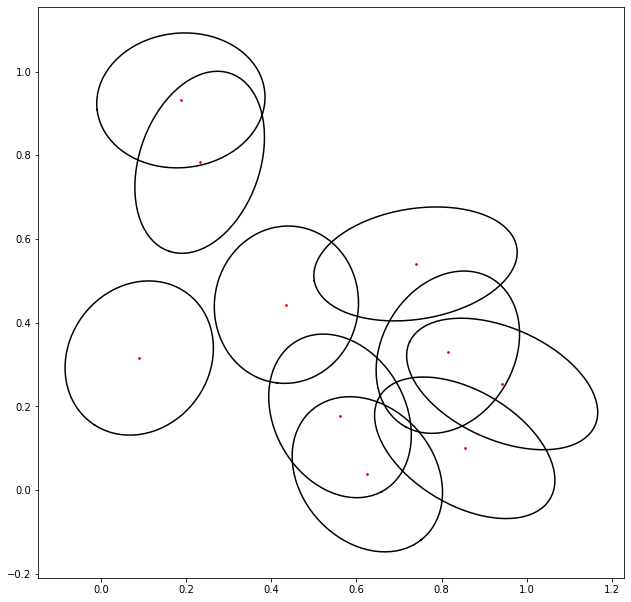

In [22]:
apd1.plot_ellipses()

In [23]:
apd1.new_Lloyds_algorithm(adjust_As = True)

Lloyds iteration: 0
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.5692541599273682
Lloyds iteration: 1
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.7213950157165527
Lloyds iteration: 2
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.9295642375946045
Lloyds iteration: 3
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.7734373211860657
Lloyds iteration: 4
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.42353570461273193


(<Figure size 756x756 with 1 Axes>, <Axes: >)

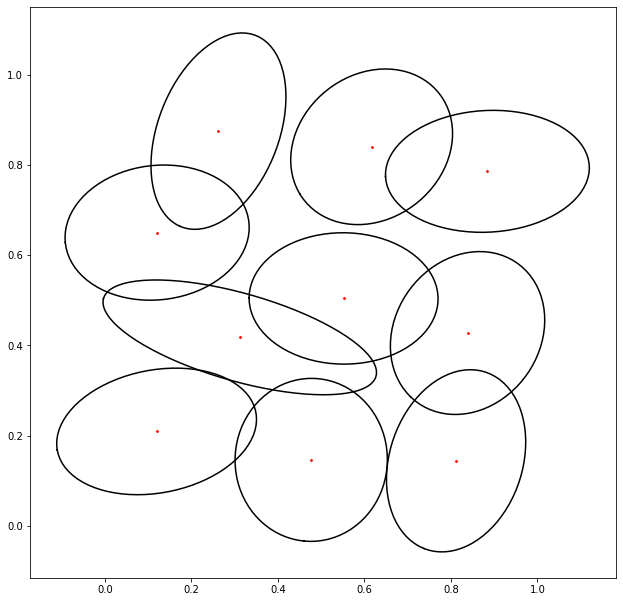

In [24]:
apd1.plot_ellipses()

(<Figure size 756x756 with 1 Axes>, <Axes: >)

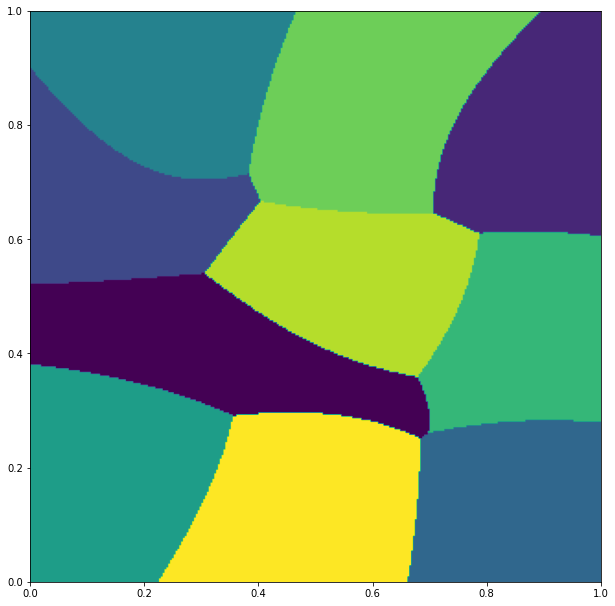

In [25]:
apd1.plot_apd()

(<Figure size 756x756 with 1 Axes>, <Axes: >)

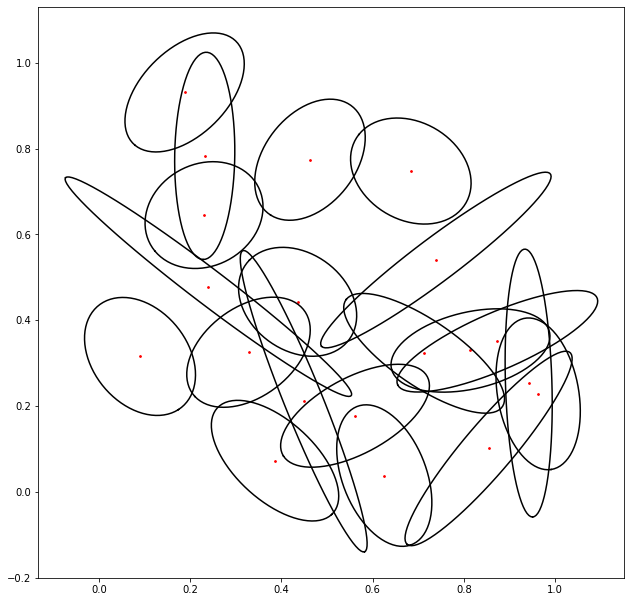

In [51]:
# Construct an APD system:
apd1 = apd_system(D=2, N = 20,
                    ani_thres = 0.7,
                    pixel_size_prefactor = 5,seed = 20)

apd1.assemble_pixels()
apd1.plot_ellipses()

In [52]:
apd1.new_Lloyds_algorithm(K=30,verbosity_level = 2, adjust_As = False)

Lloyds iteration: 0
Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.0005000000)
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: -0.027925
         Iterations: 13
         Function evaluations: 16
It took 0.12901806831359863 seconds to find optimal W.
The APD is optimal!
Percentage error =  0.617586076259613
Lloyds iteration: 1
Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.0005000000)
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: -0.013974
         Iterations: 13
         Function evaluations: 15
It took 0.08542943000793457 seconds to find optimal W.
The APD is optimal!
Percentage error =  0.663362443447113
Lloyds iteration: 2
Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.0005000000)
Optimality condition successfully overwritten.
Optimizati

(<Figure size 756x756 with 1 Axes>, <Axes: >)

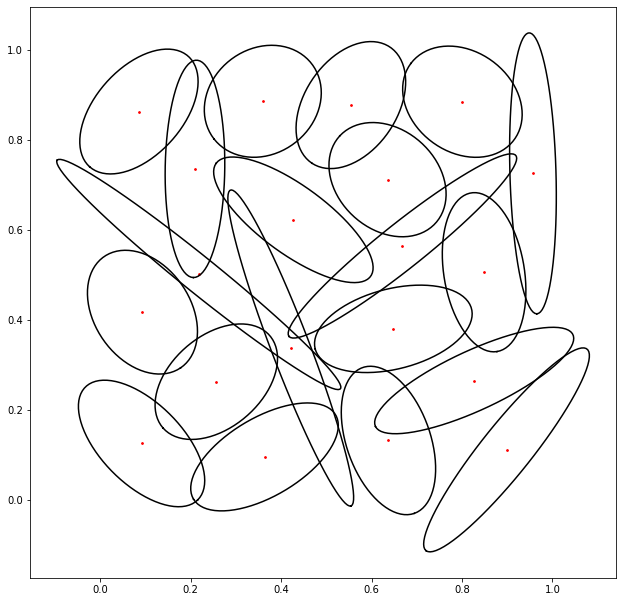

In [53]:
apd1.plot_ellipses()

(<Figure size 756x756 with 1 Axes>, <Axes: >)

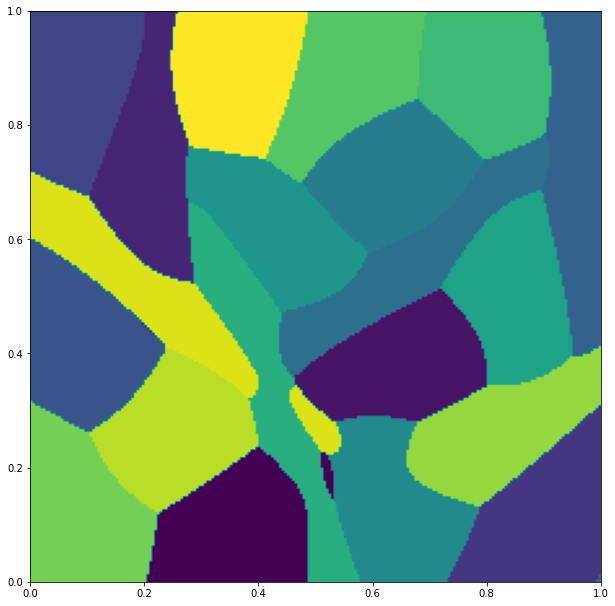

In [54]:
apd1.plot_apd()

(<Figure size 756x756 with 1 Axes>, <Axes: >)

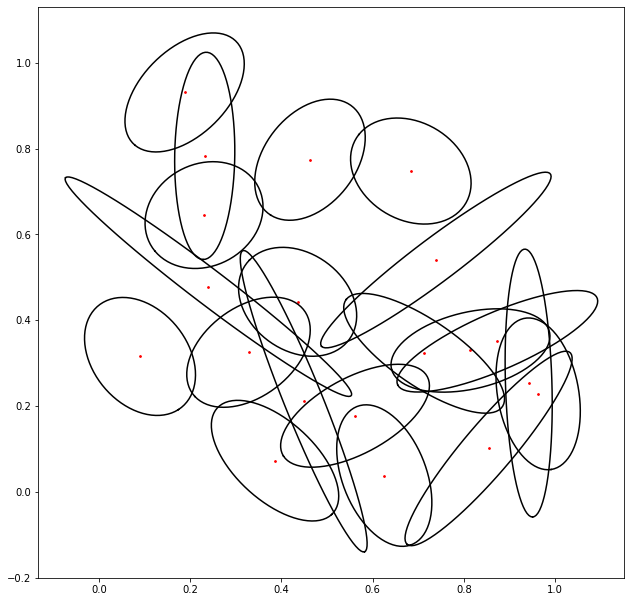

In [55]:
# Construct an APD system:
apd1 = apd_system(D=2, N = 20,
                    ani_thres = 0.7,
                    pixel_size_prefactor = 5,seed = 20)

apd1.assemble_pixels()
apd1.plot_ellipses()

In [56]:
apd1.new_Lloyds_algorithm(K=30,adjust_As = True,verbosity_level = 2)

Lloyds iteration: 0
Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.0005000000)
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: -0.027925
         Iterations: 13
         Function evaluations: 16
It took 0.11993694305419922 seconds to find optimal W.
The APD is optimal!
Percentage error =  0.617586076259613
Lloyds iteration: 1
Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.0005000000)
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: -0.015393
         Iterations: 16
         Function evaluations: 17
It took 0.10497140884399414 seconds to find optimal W.
The APD is optimal!
Percentage error =  0.4109814763069153
Lloyds iteration: 2
Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.0005000000)
Optimality condition successfully overwritten.
Optimizat

(<Figure size 756x756 with 1 Axes>, <Axes: >)

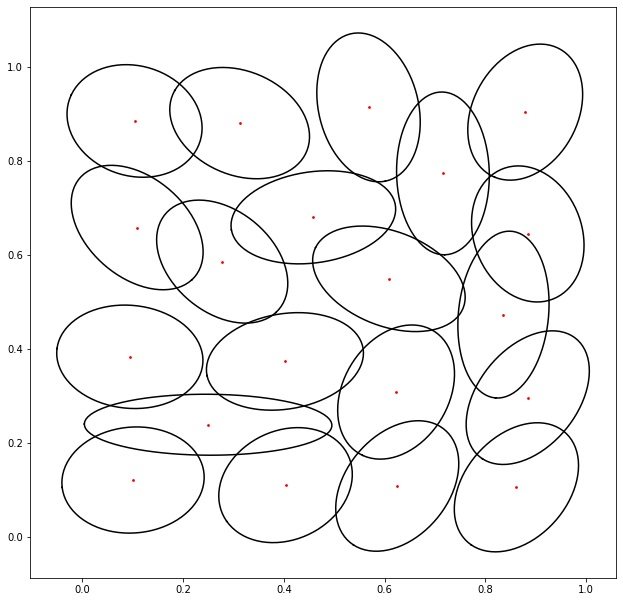

In [57]:
apd1.plot_ellipses()

(<Figure size 756x756 with 1 Axes>, <Axes: >)

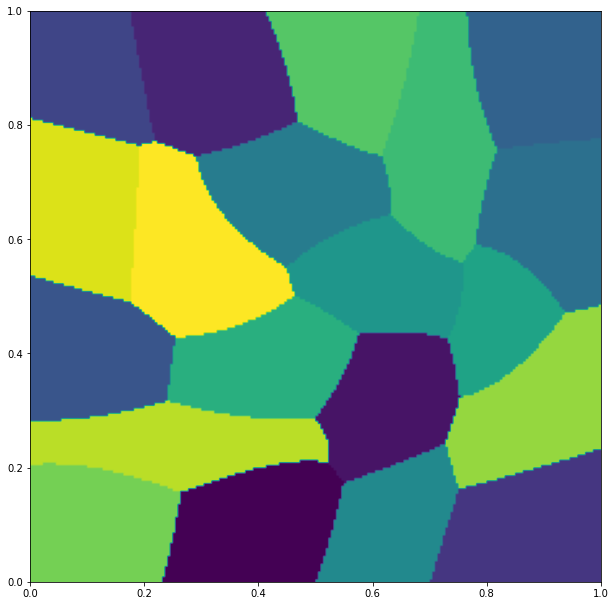

In [58]:
apd1.plot_apd()